In [2]:
using Images
using Statistics
using Plots
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology

In [3]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [4]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

In [269]:
# Modified for mutli-signal to return times instead of time-crops
# Smooth signal for finding half-max time to exclude noisy peaks
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    smoothed = (signal[1:end-2] + signal[2:end-1] + signal[3:end]) / 3
    start = Integer(findall(smoothed .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

163:343

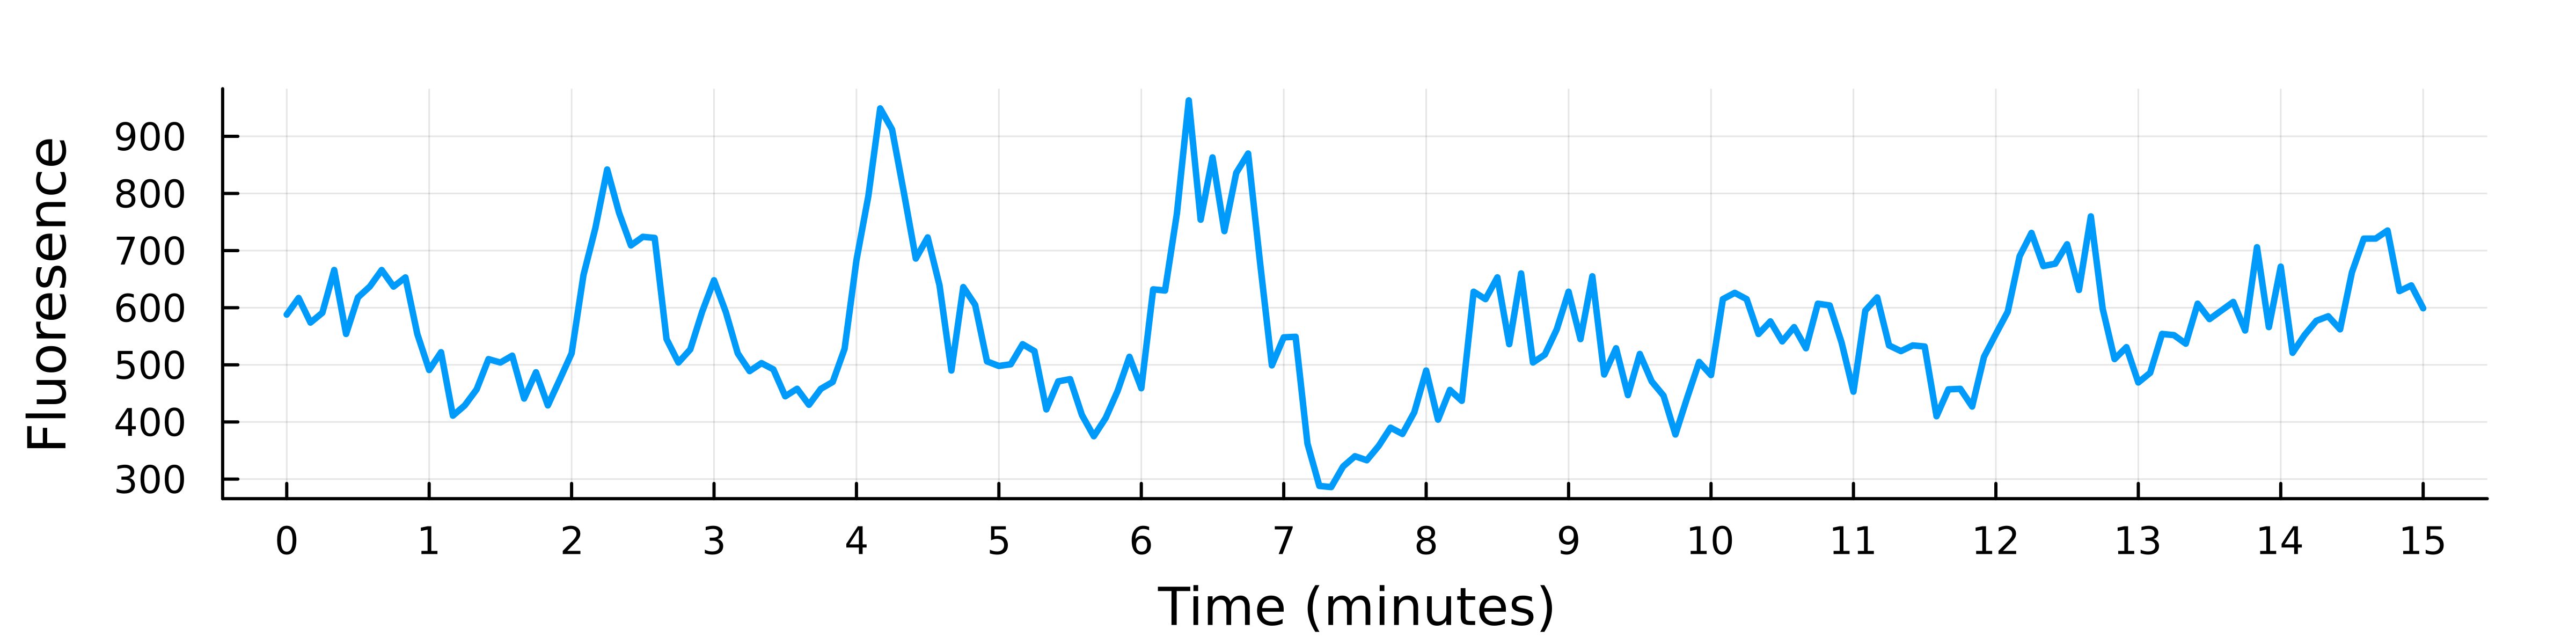

In [281]:
file = "../data/2024_10_10-3XGBwt/crops/movie3-cell12.tif"
file = "../data/2024_10_10-3XGBwt/crops/movie3-cell21.tif"
#file = "../data/2024_10_10-3XGBwt/crops/movie3-cell27.tif"
interval = 5
time_threshold=0.45
masks = mask_site(file, 0.5, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q3 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
q5 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
print(times_max1)
crop1 = q1[times_max1]
crop3 = q3[times_max1]
crop5 = q5[times_max1]
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, dpi=600,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGB_1site_m3c21.png")

77:257

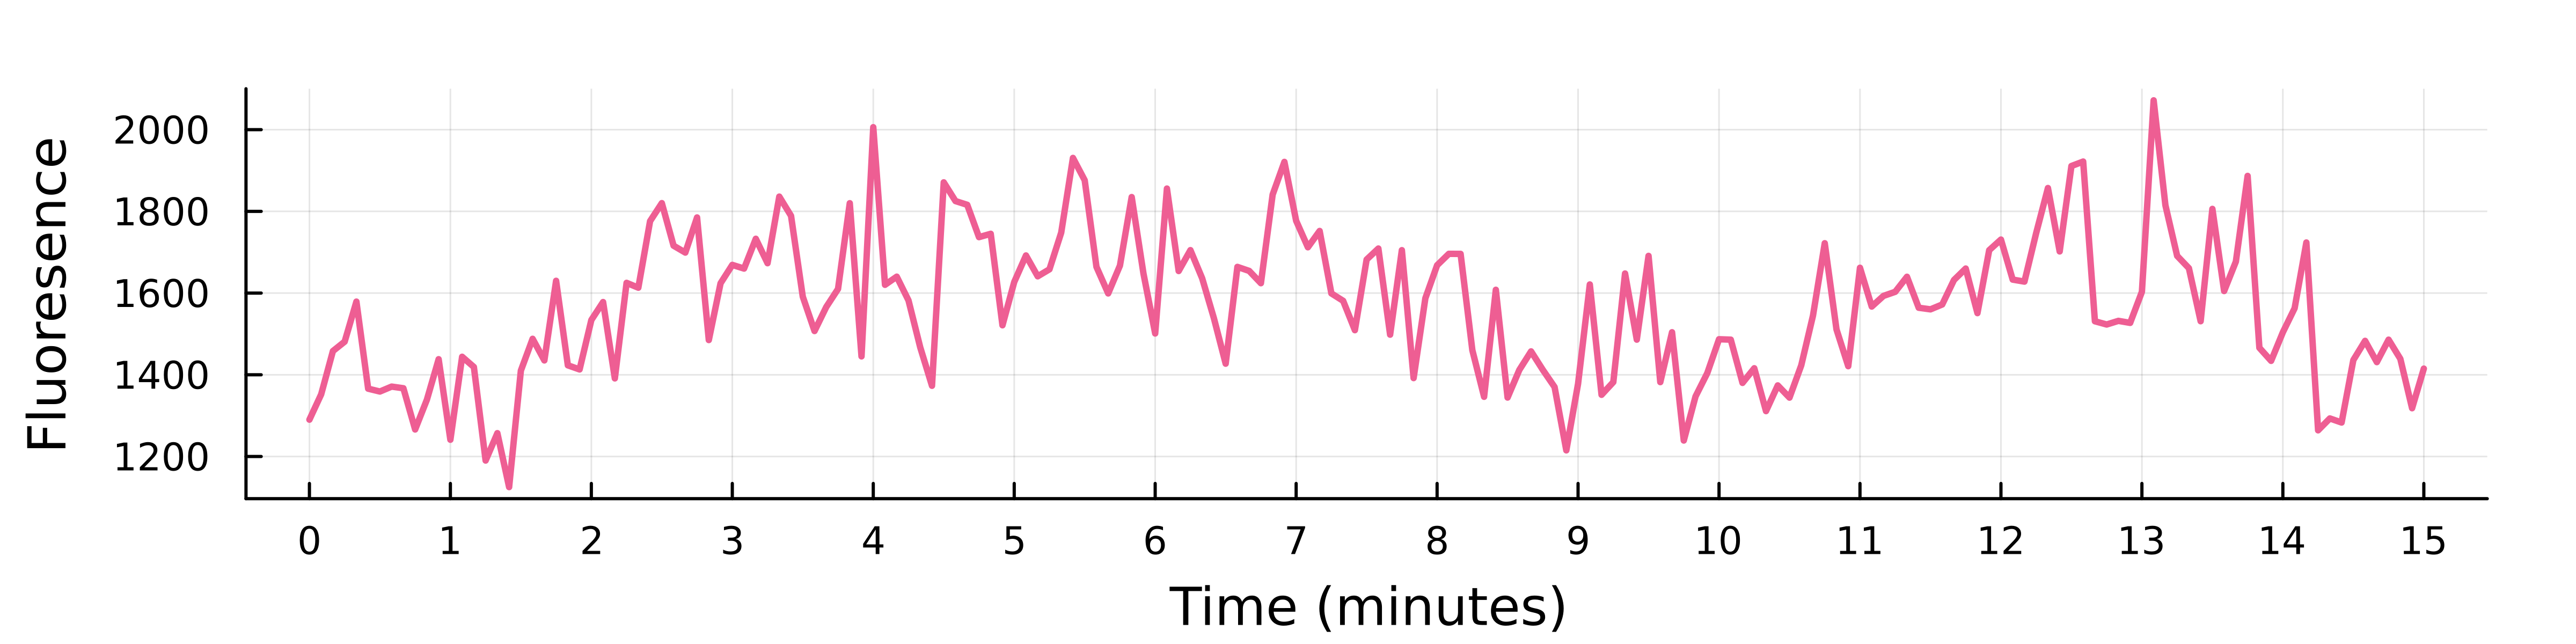

In [356]:
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell18.tif"
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell20.tif"
interval = 5
time_threshold=0.5
masks = mask_site(file, 0.3, n_sites=1);
im_size = length(masks[:,1,1,1])*length(masks[1,:,1,1])
m1 = masks[:,:,:,1]
q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
q3 = vquantile(m1, (im_size-3)/im_size, dims=(1,2))[1,1,:]
q5 = vquantile(m1, (im_size-5)/im_size, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
print(times_max1)
crop1 = q1[times_max1]
crop3 = q3[times_max1]
crop5 = q5[times_max1]
t = range(0,60/5*15)*(5/60) # Convert from 1 frame every 5 sec, to minutes
plot(t, crop1, xticks=range(0,15), linewidth=2, label=false, dpi=600, color=7,
    xlabel="Time (minutes)", ylabel="Fluoresence", size=(800,200), margin=5Plots.mm)
#savefig("../figures/3XGBpak1_1site_m10c20.png")

.....

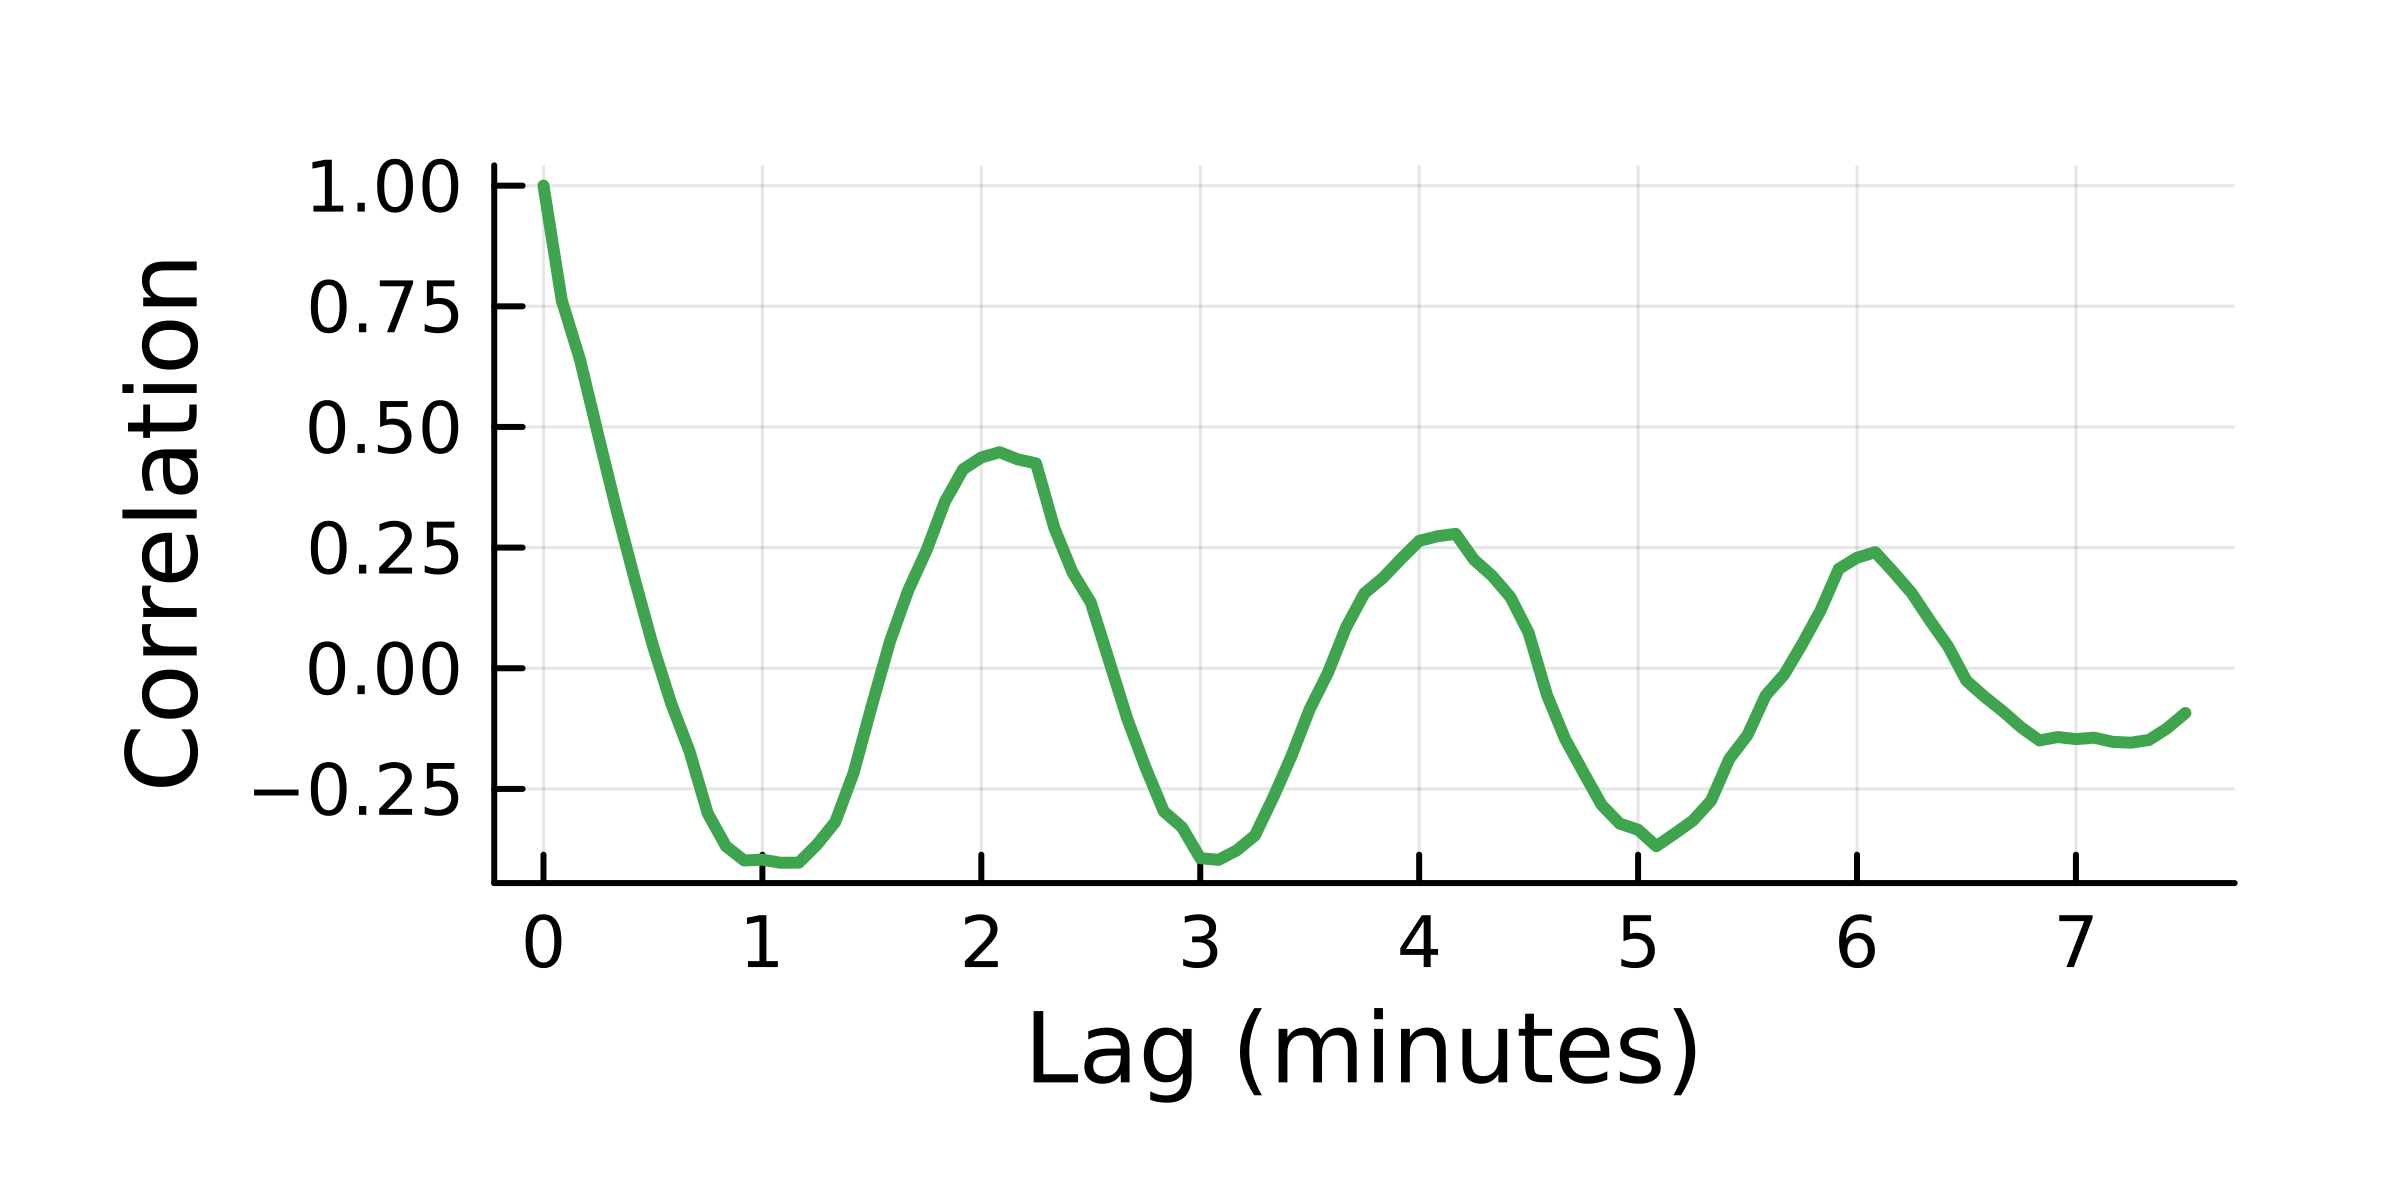

In [425]:
dir = "../data/2024_10_10-3XGBwt/crops/"
wt_files = readdir(dir)
all_cor = zeros(91, ((length(wt_files))))
t_cor = range(0,90)*(5/60)
peaks_ac = zeros(length(wt_files))
n = 0
cov_threshold = 0.5
max_powers=zeros(95)
frequencies = 0
I_wt = zeros(length(wt_files))
diff_wt = zeros(length(wt_files))
for f in wt_files
    n+=1
    patches = mask_site("$dir$f", cov_threshold, n_sites=1)
    patch1 = patches[:,:,:,1]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    crop1 = max_patch1[times_max1]
    plot(times_max1, crop1, linewidth=2, label=false, color=1, size=(400,100),
        dpi=600, grid=false, yticks=false, xticks=false, framestyle = :box)
    cell = replace(f,".tif" => "")
    #savefig("../figures/naked_traces/wt/3xGB_wt_$cell")
    #pdg
    pdg_max = DSP.Periodograms.periodogram(crop1)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    #ac
    ac = crosscor(crop1, crop1, 0:90)
    all_cor[:,n] = ac
    mac = findlocalmaxima(ac, window=(3,), edges=false)
    I_wt[n] = mean(crop1)
    diff_wt[n] = mean(crop1[1:end-1] .- crop1[2:end])
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        peaks_ac[n] = mac[1] * (5/60)
    end
end
plot(t_cor, mean(all_cor,dims=(2)), x_ticks=0:8, label=false, color=3, linewidth=6, size=(400,250), alpha=0.5,
    xlabel="Lag (minutes)", ylabel="Correlation", dpi=600, margin=5Plots.mm)

file = "../data/2024_10_10-3XGBwt/crops/movie3-cell21.tif"
m = mask_site(file, cov_threshold, n_sites=1)
max_patch = maximum(m, dims=(1,2))[1,1,:]
times_max = crop_times(max_patch, 15*(60/5), 0.5)
crop = max_patch[times_max]
ac = crosscor(crop, crop, 0:90)
plot!(t_cor, ac, linewidth=2, color=1, label=false)
#savefig("../figures/3xGB_wt_ac")
plot(t_cor, ac, x_ticks=0:8, label=false, color=3, linewidth=2, size=(400,200), alpha=1,
    xlabel="Lag (minutes)", ylabel="Correlation", dpi=600, margin=5Plots.mm)
#savefig("../figures/3xGB_wt_ac_example")

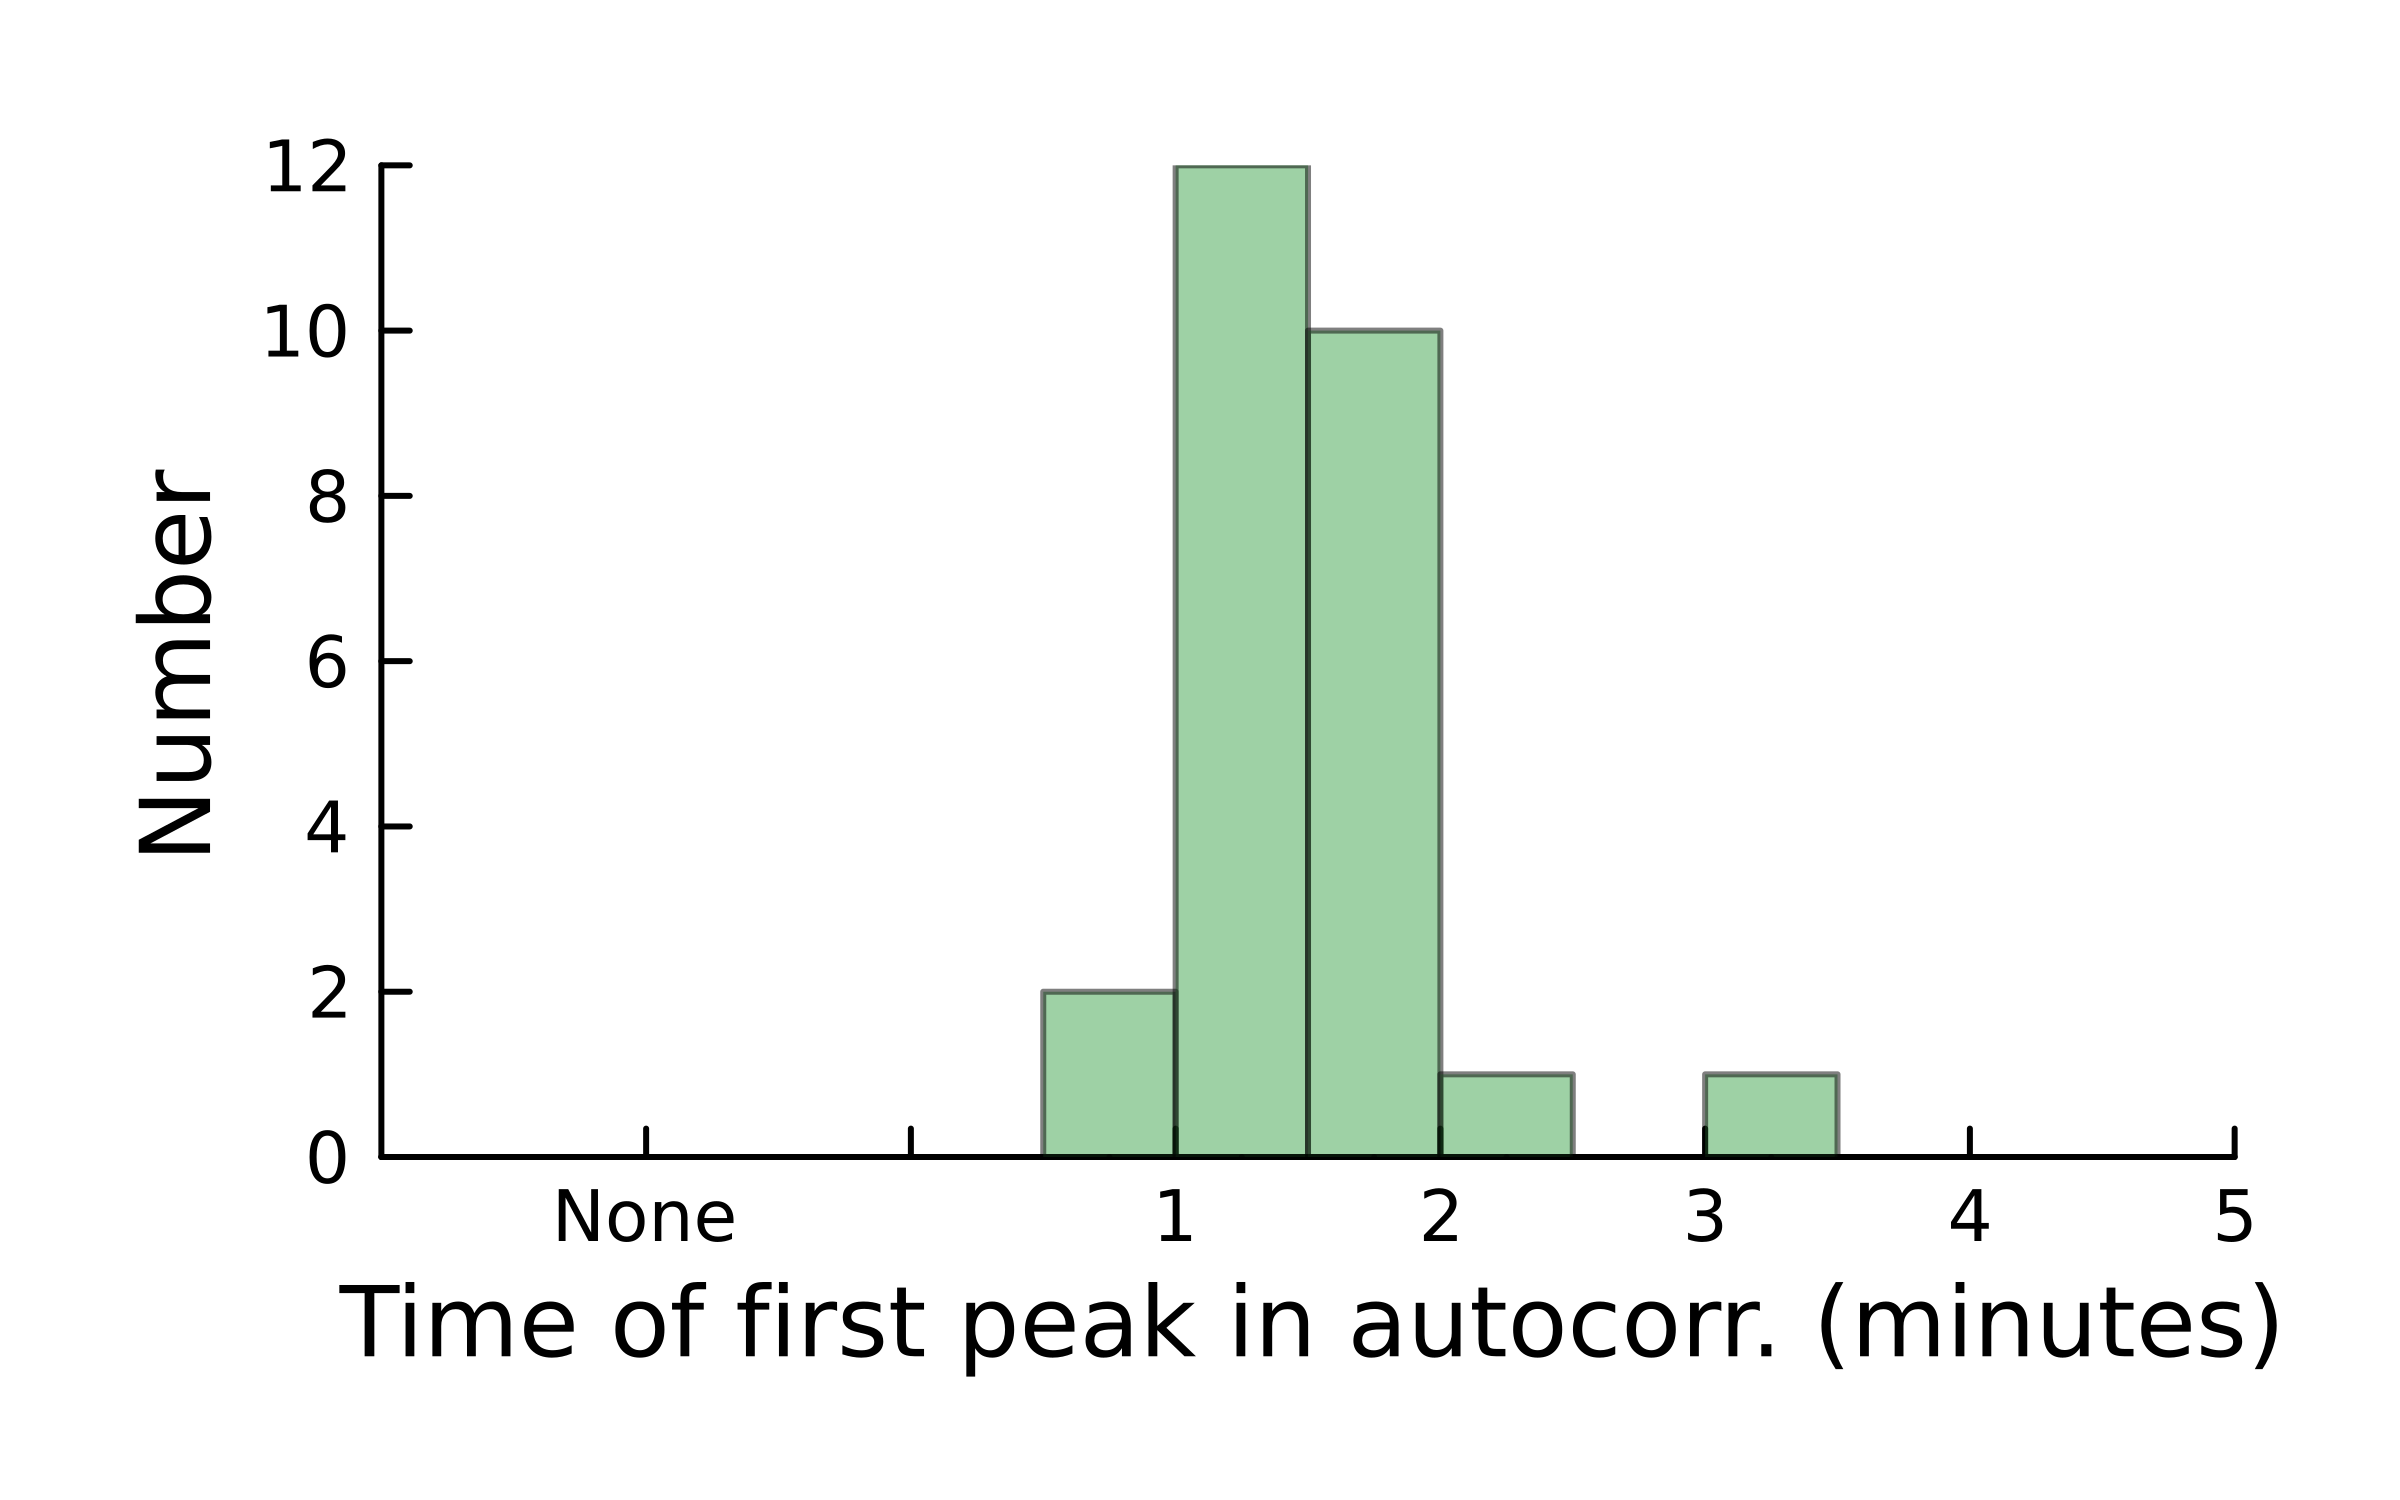

In [426]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks)) .-1.25
histogram(peaks, alpha=0.5,bins=0:0.5:5, grid=false, legend=false, xticks=(-1:7, ("None","",1,2,3,4,5)), dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
histogram!(nonpeaks, bins=-1.25:0.5:5, alpha=0.5, color="red", xlims=(-2,5))
#savefig("../figures/3xGB_wt_ac_histogram.png")

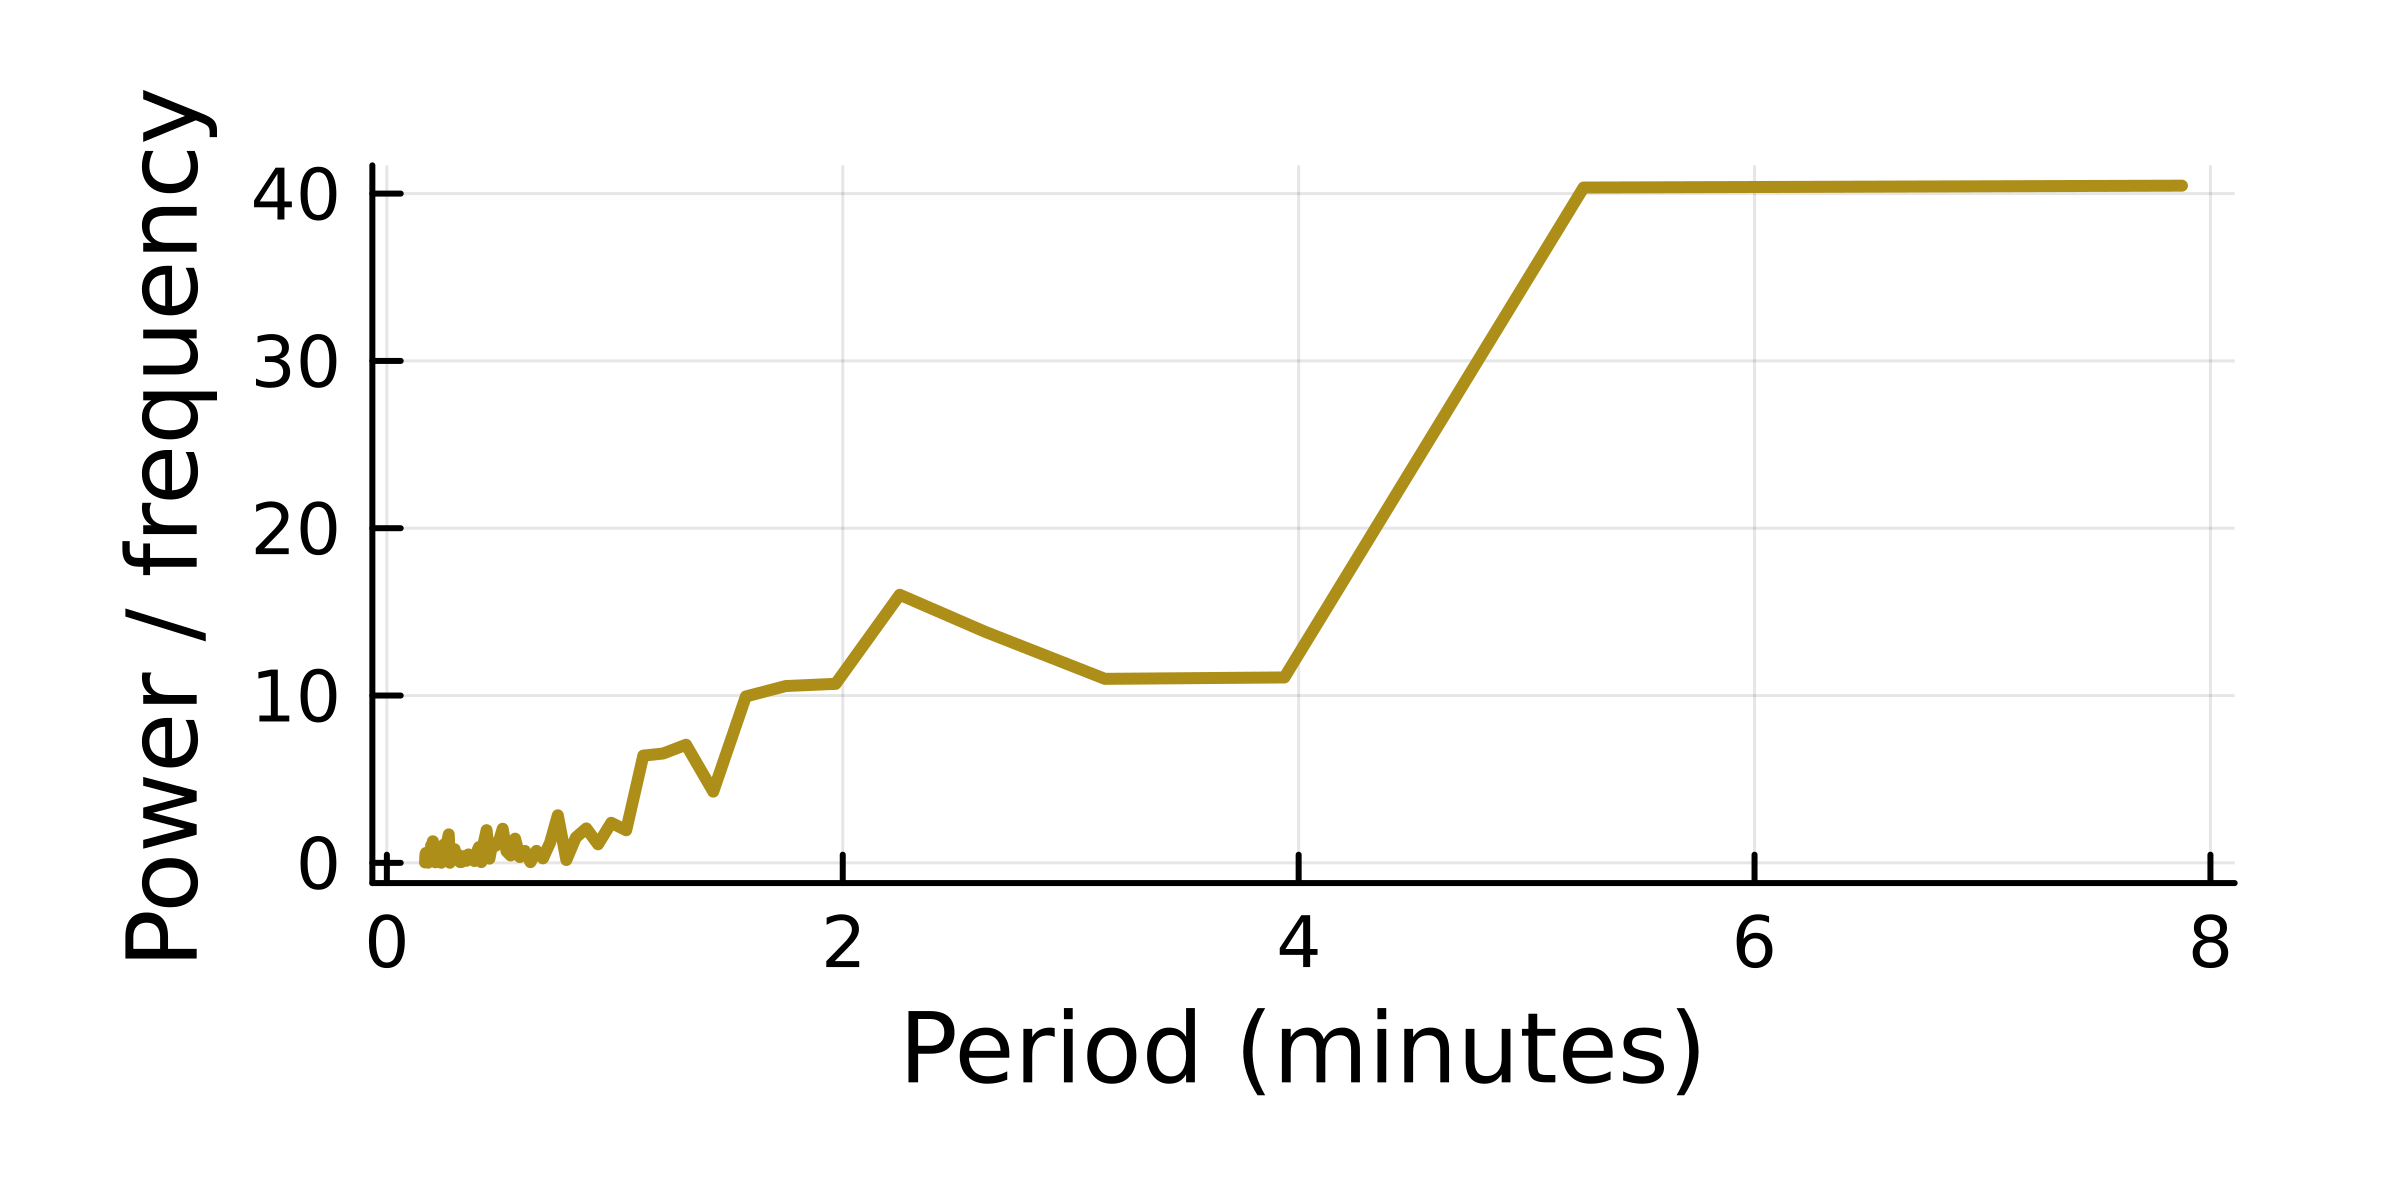

In [432]:
plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n/10^5, xflip = false, size=(400,250), legend=:bottomright,dpi=600,
    label=false, linewidth=6, alpha=0.5, margin=5Plots.mm, color=5, xlabel="Period (minutes)", ylabel="Power / frequency")
pdg = DSP.Periodograms.periodogram(crop)
powers = pdg.power
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=1, linewidth=2, label=false)
#savefig("../figures/3xGB_wt_powers")
plot(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=5, linewidth=2, label=false, 
    size=(400,200), legend=:bottomright,dpi=600, margin=5Plots.mm, xlabel="Period (minutes)", ylabel="Power / frequency")
#savefig("../figures/3xGB_wt_powers_example")

In [434]:
dir = "../data/2024_10_10-3XGBpak1/crops/"
wt_files = readdir(dir)
plot(ylabel="Correlation", xlabel="Lag (minutes)",
    legend=:bottomright, size=(600,400))
all_cor = zeros(91, ((length(wt_files))))
peaks_ac = zeros(length(wt_files))
t_cor = range(0,90)*(5/60)
I_del = zeros(length(wt_files))
diff_del = zeros(length(wt_files))
n = 0
cov_threshold = 0.5
max_powers=zeros(95)
for f in wt_files
    n+=1
    patches = mask_site("$dir$f", cov_threshold, n_sites=1)
    patch1 = patches[:,:,:,1]
    max_patch1 = maximum(patch1, dims=(1,2))[1,1,:]
    times_max1 = crop_times(max_patch1, 15*(60/5), 0.5)
    crop1 = max_patch1[times_max1]
    plot(times_max1, crop1, linewidth=2, label=false, color=7, size=(400,100),
        dpi=600, grid=false, yticks=false, xticks=false, framestyle = :box)
    cell = replace(f,".tif" => "")
    #savefig("../figures/naked_traces/pak1/3xGB_pak1_$cell")
    #pdg
    pdg_max = DSP.Periodograms.periodogram(crop1)
    max_powers = max_powers .+ pdg_max.power
    frequencies = pdg_max.freq
    #ac
    ac = crosscor(crop1, crop1, 0:90)
    all_cor[:,n] = ac
    k = Kernel.gaussian((2,))
    ac = imfilter(ac, k)
    mac = findlocalmaxima(ac, window=(3,), edges=false)
    I_del[n] = mean(crop1)
    diff_del[n] = mean(crop1[1:end-1] .- crop1[2:end])
    if length(mac) < 1
        continue
    else
        mac = mac[1]
        peaks_ac[n] = mac[1] * (5/60)
    end
end
plot(t_cor, mean(all_cor,dims=(2)), x_ticks=0:8, label=false, linewidth=6, color=3, size=(400,250), alpha=0.5, dpi=600,
    xlabel="Lag (minutes)", ylabel="Correlation", margin=5Plots.mm)
file = "../data/2024_10_10-3XGBpak1/crops/movie10_cell20.tif"
m = mask_site(file, cov_threshold, n_sites=1)
max_patch = maximum(m, dims=(1,2))[1,1,:]
times_max = crop_times(max_patch, 15*(60/5), 0.5)
crop = max_patch[times_max]
ac = crosscor(crop, crop, 0:90)
plot!(t_cor, ac, linewidth=2, color=7, label=false)
#savefig("../figures/3xGB_pak1_ac")
plot(t_cor, ac, x_ticks=0:8, label=false, color=3, linewidth=2, size=(400,200), alpha=1,
    xlabel="Lag (minutes)", ylabel="Correlation", dpi=600, margin=5Plots.mm)
savefig("../figures/3xGB_pak1_ac_example")

....

"/home/dinosaur/Lab/Polarity/proj/fig6-deletions/figures/3xGB_pak1_ac_example.png"

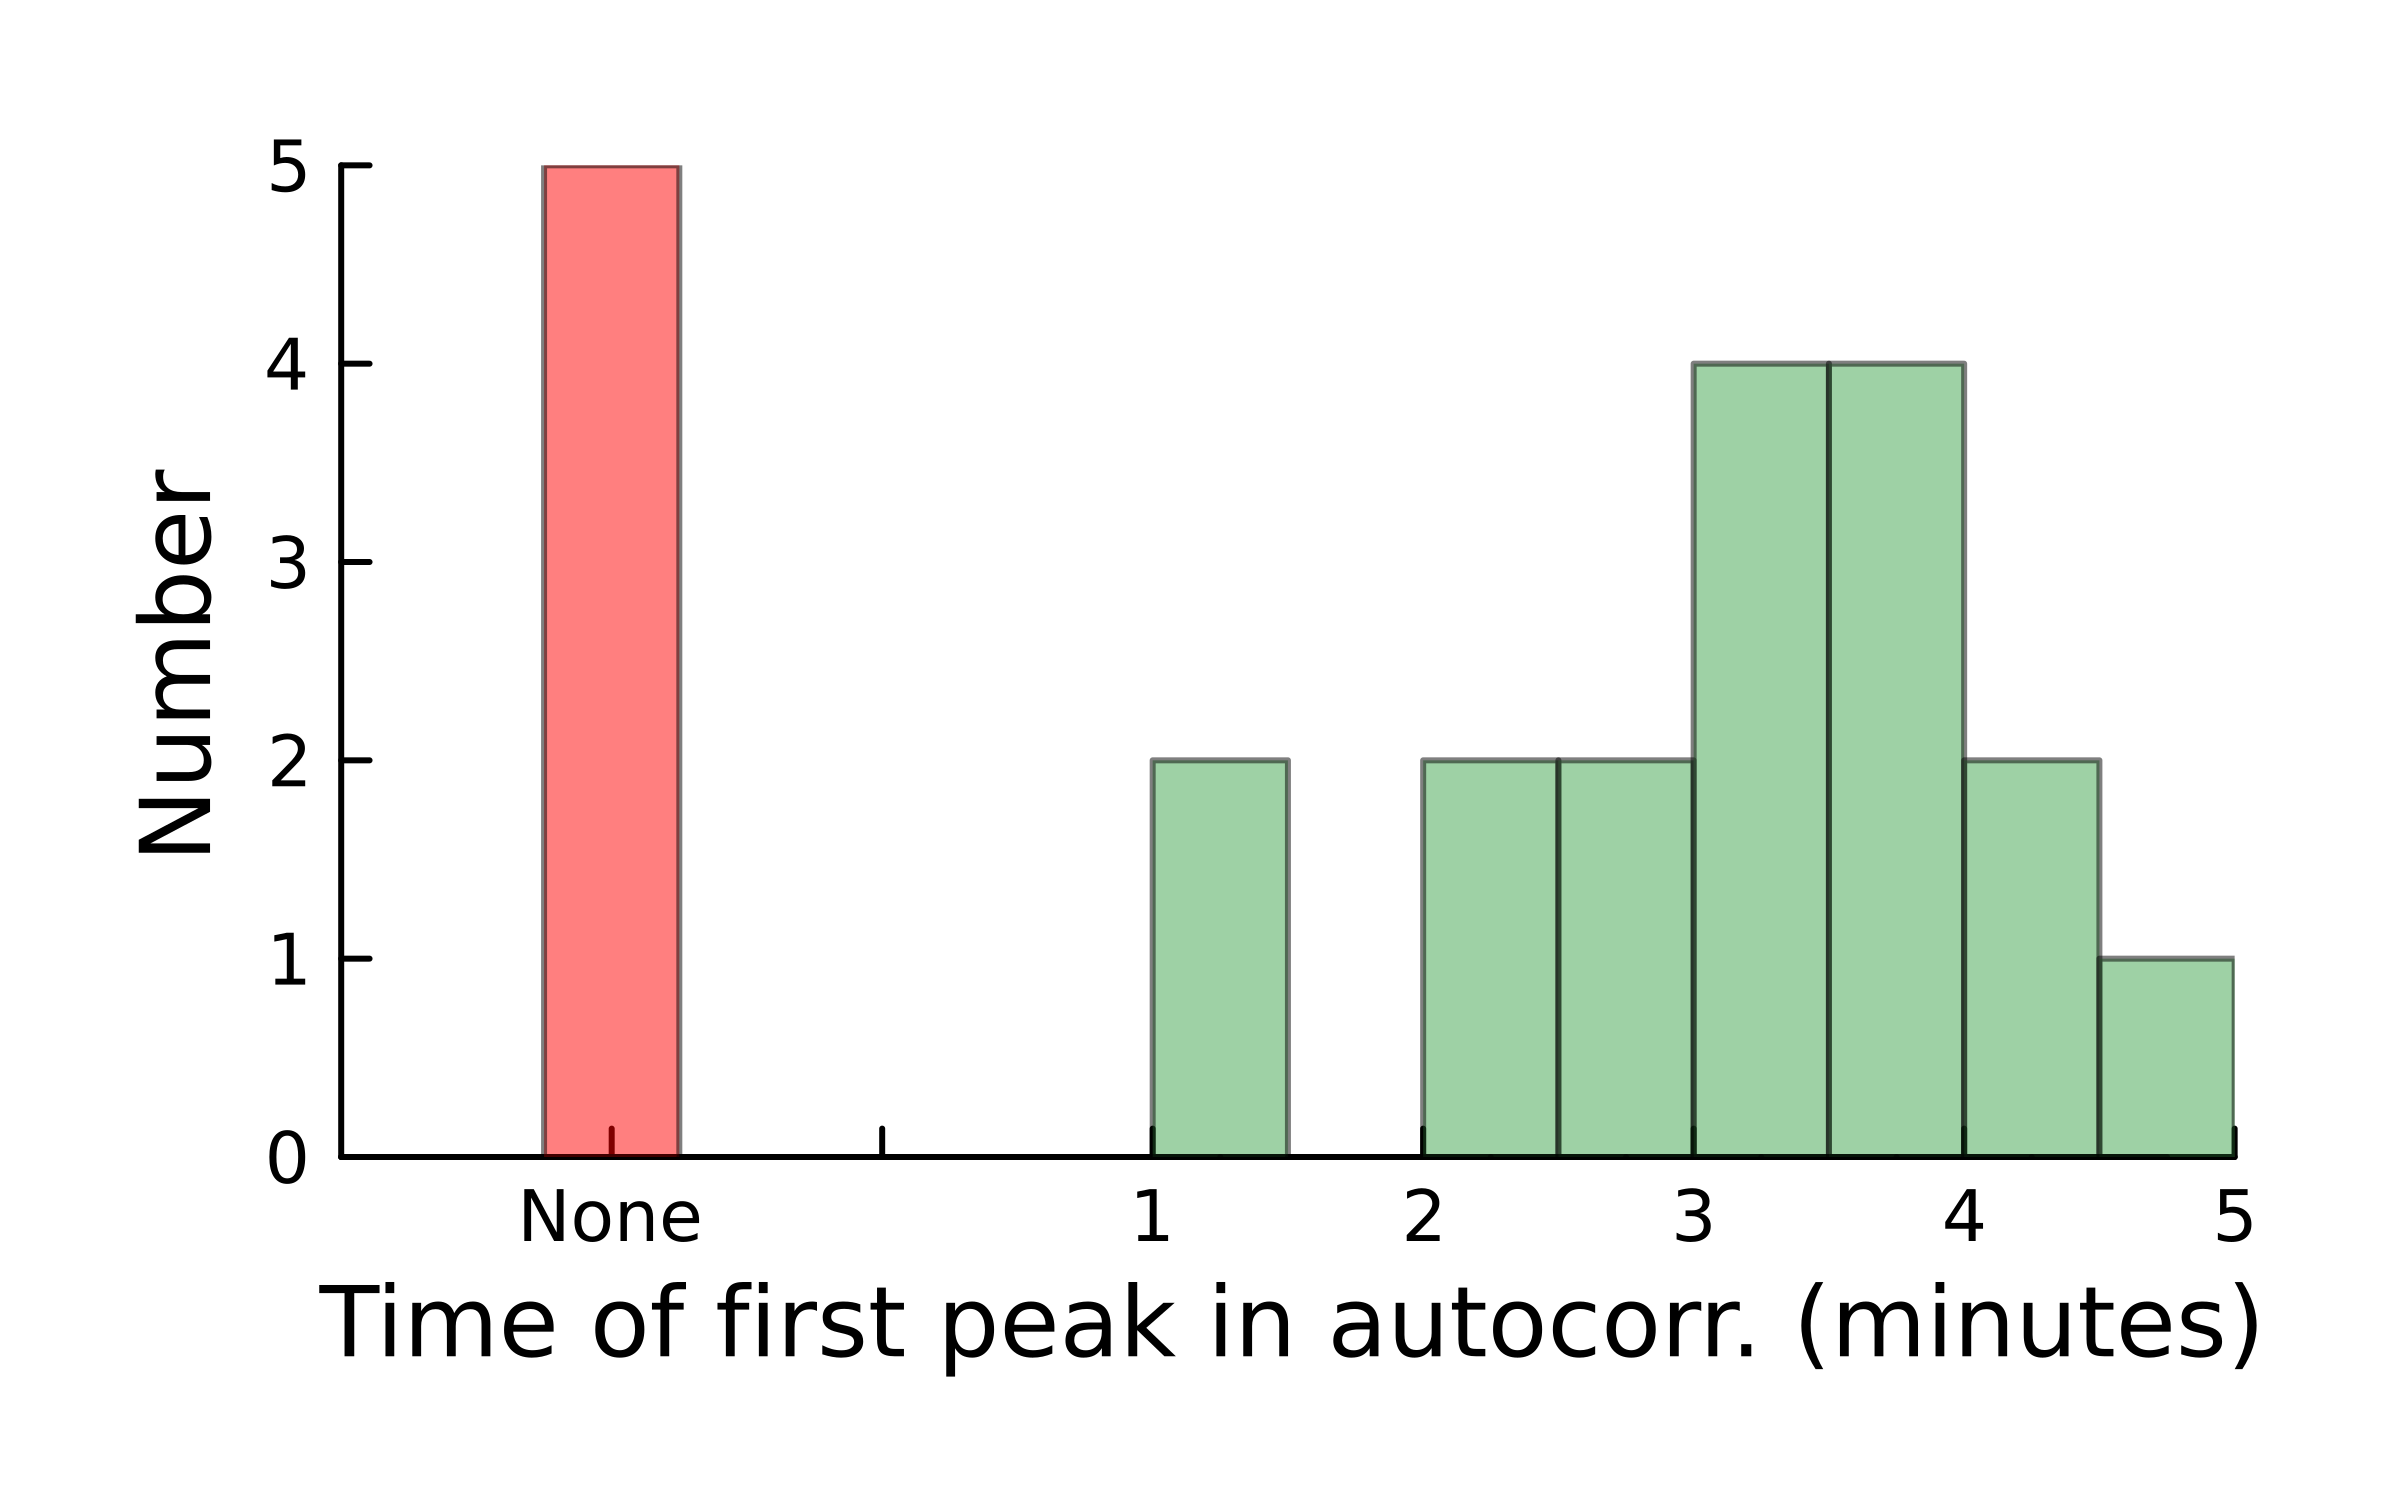

In [404]:
peaks = filter(x -> x>0.0 && x<5,peaks_ac)
nonpeaks = filter(x -> x==0.0 || x>5,peaks_ac)
nonpeaks = zeros(length(nonpeaks)) .-1.25
histogram(peaks, alpha=0.5,bins=0:0.5:5, grid=false, legend=false, xticks=(-1:7, ("None","",1,2,3,4,5)), dpi=600, size=(400,250), color=3,
    xlabel="Time of first peak in autocorr. (minutes)", ylabel="Number", margin=5Plots.mm)
histogram!(nonpeaks, bins=-1.25:0.5:5, alpha=0.5, color="red", xlims=(-2,5))
#savefig("../figures/3xGB_pak1_ac_histogram.png")

In [435]:
plot(1 ./ frequencies[3:end] .* (5/60), max_powers[3:end]/n/10^5, xflip = false, size=(400,250), legend=:bottomright, dpi=600,
    label=false, linewidth=6, alpha=0.5, margin=5Plots.mm, color=5, xlabel="Period (minutes)", ylabel="Power / frequency")
pdg = DSP.Periodograms.periodogram(crop)
powers = pdg.power
plot!(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=7, linewidth=2, label=false)
#savefig("../figures/3xGB_pak1_powers")
plot(1 ./ frequencies[3:end] .* (5/60), powers[3:end]/10^5, color=5, linewidth=2, label=false, 
    size=(400,200), legend=:bottomright,dpi=600, margin=5Plots.mm, xlabel="Period (minutes)", ylabel="Power / frequency")
savefig("../figures/3xGB_pak1_powers_example")

"/home/dinosaur/Lab/Polarity/proj/fig6-deletions/figures/3xGB_pak1_powers_example.png"

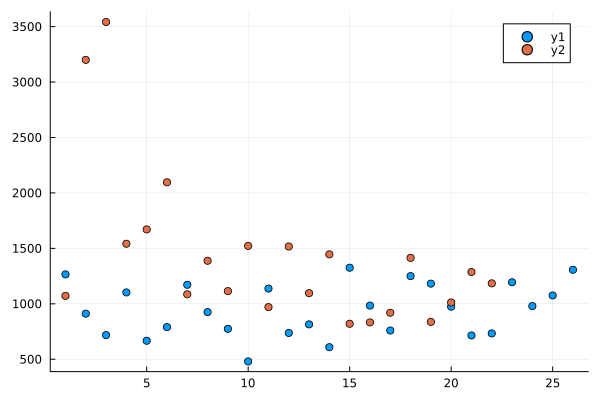

In [295]:
scatter([abs.(I_wt), abs.(I_del)])

In [263]:
diff_wt

26-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0